In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_data(filename):
    #dir = os.path.dirname('__file__')
    #f = os.path.join(dir, '..', 'data', filename)
    df = pd.read_csv(filename, delimiter=',')
    return df

In [3]:
ratings = read_data('ratings.csv')
movies = read_data('movies.csv')

R = ratings.pivot_table(index=['userId'], columns=['movieId'], values='rating', 
                                fill_value=0, dropna=False)
R.unstack()
R = R.unstack().reset_index(name='rating')
R.rename(columns={'level_0': 'userId', 'level_1': 'movieId'}, inplace=True)

In [4]:
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection.validation import cross_validate
from surprise import Dataset
from surprise import Reader

def NMF_filter(ratings, dims):
    reader = Reader(rating_scale=(0.0, 5.0))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    RMSE = np.empty([len(dims)])
    MAE = np.empty([len(dims)])
    min_RMSE = False
    min_MAE = False
    fac_num_RMSE = 0
    fac_num_MAE = 0

    for k in range(len(dims)):
        nmf = NMF(n_factors=dims[k], biased = False)
        cv = cross_validate(algo=nmf, data=data, measures=['RMSE', 'MAE'],
                            cv=10, verbose=True)
        RMSE[k] = np.mean(cv['test_rmse']) 
        if ((not min_RMSE) or RMSE[k] < min_RMSE):
            min_RMSE = RMSE[k]
            fac_num_RMSE = dims[k]

        MAE[k] = np.mean(cv['test_mae'])
        if ((not min_MAE) or MAE[k] < min_MAE):
            min_MAE = MAE[k]
            fac_num_MAE = dims[k]

    plt.plot(dims, RMSE)
    plt.plot(dims, MAE)
    plt.legend(['RMSE', 'MAE'])
    plt.show()
    print ('Finishing Plotting...')
    print ('For RMSE:')
    print ('\t---Optimal number of latent factors is ', fac_num_RMSE)
    print ('\t---Minumun Average RMSE is ', min_RMSE)
    print ('\nFor MAE:')
    print ('\t---Optimal number of latent factors is ', fac_num_MAE)
    print ('\t---Minumun Average MAE is ', min_MAE)

Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     1.4780  1.4852  1.5031  1.4934  1.4798  1.5009  1.4812  1.4866  1.5111  1.4945  1.4914  0.0105  
RMSE (testset)    1.6557  1.6628  1.6800  1.6700  1.6660  1.6759  1.6597  1.6628  1.6873  1.6736  1.6694  0.0093  
Fit time          3.54    3.94    3.95    3.27    3.28    3.28    3.26    3.26    3.21    3.03    3.40    0.30    
Test time         0.08    0.10    0.07    0.07    0.07    0.08    0.08    0.07    0.07    0.07    0.08    0.01    
Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     1.2483  1.2444  1.2561  1.2523  1.2376  1.2683  1.2637  1.2434  1.2748  1.2576  1.2546  0.0112  
RMSE (testset)    1.4294  1.4267  1.4384  1.4324  1.4234  1.4484  1.4439  1.4302  1.4

Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.7508  0.7482  0.7445  0.7632  0.7508  0.7654  0.7632  0.7517  0.7576  0.7449  0.7540  0.0074  
RMSE (testset)    0.9940  0.9911  0.9949  1.0143  1.0020  1.0116  1.0072  1.0012  1.0094  0.9965  1.0022  0.0077  
Fit time          7.50    7.72    7.84    7.87    7.92    7.84    7.87    7.67    7.35    6.88    7.65    0.31    
Test time         0.08    0.08    0.09    0.08    0.08    0.08    0.07    0.07    0.07    0.06    0.08    0.01    
Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.7687  0.7593  0.7632  0.7547  0.7592  0.7704  0.7657  0.7639  0.7692  0.7660  0.7640  0.0048  
RMSE (testset)    1.0144  1.0086  1.0177  1.0049  1.0108  1.0170  1.0158  1.0194  1.0

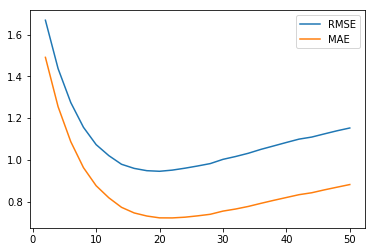

Finishing Plotting...
For RMSE:
	---Optimal number of latent factors is  20
	---Minumun Average RMSE is  0.945021147330791

For MAE:
	---Optimal number of latent factors is  22
	---Minumun Average MAE is  0.7213783387686792


In [4]:
# Q17
dims = range(2, 51, 2)
NMF_filter(ratings, dims)


In [5]:
from surprise.model_selection import KFold
from surprise import accuracy

def NMF_trim_filter(ratings, dims, func, mv_dict):
    reader = Reader(rating_scale=(0.0, 5.0))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    RMSE = np.empty([len(dims)])
    MAE = np.empty([len(dims)])
    min_RMSE = False
    min_MAE = False
    fac_num_RMSE = 0
    fac_num_MAE = 0
    kf = KFold(n_splits=10, random_state=42)

    for k in range(len(dims)):
        nmf = NMF(n_factors=dims[k], random_state=42)
        test_rmse = np.array([])
        test_mae = np.array([])
        for trainset, testset in kf.split(data):
            nmf.fit(trainset)
            full_data = trainset.build_testset() + testset
            func(mv_dict, testset)
            pred = nmf.test(testset)
            test_rmse = np.append(test_rmse, accuracy.rmse(pred, verbose=False))
            test_mae = np.append(test_mae, accuracy.mae(pred, verbose=False))
        RMSE[k] = np.mean(test_rmse) 
        if ((not min_RMSE) or RMSE[k] < min_RMSE):
            min_RMSE = RMSE[k]
            fac_num_RMSE = dims[k]

        MAE[k] = np.mean(test_mae)
        if ((not min_MAE) or MAE[k] < min_MAE):
            min_MAE = MAE[k]
            fac_num_MAE = dims[k]
        print ('For k = %i :' %dims[k])
        print ('RMSE: ', RMSE[k])
        print ('MAE: ', MAE[k])

    plt.plot(dims, RMSE)
    plt.plot(dims, MAE)
    plt.legend(['RMSE', 'MAE'])
    plt.show()
    print ('Finishing Plotting...')
    print ('For RMSE:')
    print ('\t---Optimal number of latent factors is ', fac_num_RMSE)
    print ('\t---Minumun Average RMSE is ', min_RMSE)
    print ('\nFor MAE:')
    print ('\t---Optimal number of latent factors is ', fac_num_MAE)
    print ('\t---Minumun Average MAE is ', min_MAE)
    
def pop_trim(mv_dict, test):
    test[:] = [ts for ts in test if len(mv_dict[ts[1]]) > 2]

def unpop_trim(mv_dict, test):
    test[:] = [ts for ts in test if len(mv_dict[ts[1]]) <= 2]

def high_var_trim(mv_dict, test):
    test[:] = [ts for ts in test 
               if len(mv_dict[ts[1]]) >= 5 and 
               np.var(mv_dict[ts[1]]) >= 2]
    
def movie_counter(full_data):
    mv_ratings = {}
    for data in full_data:
        if data[1] not in mv_ratings.keys():
            mv_ratings[data[1]] = [data[2]]
        else:
            mv_ratings[data[1]].append(data[2])
    return mv_ratings

In [6]:
# Generate the dictionary of all movies
from surprise.model_selection import train_test_split
reader = Reader(rating_scale=(0.0, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
empty_ds, full_ds = train_test_split(data, test_size=1.0, random_state=42)
mv_dict = movie_counter(full_ds)

For k = 2 :
RMSE:  1.698260333872731
MAE:  1.526778555222235
For k = 4 :
RMSE:  1.446813075421894
MAE:  1.2690058679073783
For k = 6 :
RMSE:  1.2743647630258264
MAE:  1.0909707856415005
For k = 8 :
RMSE:  1.1429122398708804
MAE:  0.9564166640882732
For k = 10 :
RMSE:  1.052019206374203
MAE:  0.8617653067082414
For k = 12 :
RMSE:  1.0025296721492334
MAE:  0.8066888404707507
For k = 14 :
RMSE:  0.9612273560965672
MAE:  0.7614040199407975
For k = 16 :
RMSE:  0.9348306729245234
MAE:  0.7305365597097772
For k = 18 :
RMSE:  0.9269706412513761
MAE:  0.7158585672027127
For k = 20 :
RMSE:  0.9247734817122139
MAE:  0.7061819197435841
For k = 22 :
RMSE:  0.9286066532391487
MAE:  0.705076952403741
For k = 24 :
RMSE:  0.9377801804404531
MAE:  0.7099895442377275
For k = 26 :
RMSE:  0.950068845166393
MAE:  0.7162459077426192
For k = 28 :
RMSE:  0.9681332732486062
MAE:  0.728223812997302
For k = 30 :
RMSE:  0.9811771509253484
MAE:  0.7370155606153089
For k = 32 :
RMSE:  0.9996176265497635
MAE:  0.7506

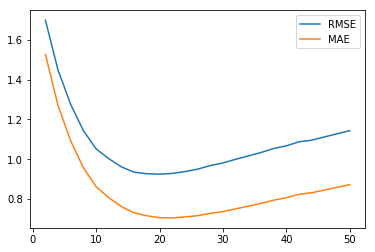

Finishing Plotting...
For RMSE:
	---Optimal number of latent factors is  20
	---Minumun Average RMSE is  0.9247734817122139

For MAE:
	---Optimal number of latent factors is  22
	---Minumun Average MAE is  0.705076952403741


In [7]:
# Q19
dims = range(2, 51, 2)
NMF_trim_filter(ratings, dims, pop_trim, mv_dict)

For k = 2 :
RMSE:  1.473281547649107
MAE:  1.1926339166437256
For k = 4 :
RMSE:  1.4366125341490013
MAE:  1.1537636486893796
For k = 6 :
RMSE:  1.4089846182464338
MAE:  1.1254829757152056
For k = 8 :
RMSE:  1.367914271960286
MAE:  1.089519216249165
For k = 10 :
RMSE:  1.330449140805819
MAE:  1.0556594231100576
For k = 12 :
RMSE:  1.314836565882621
MAE:  1.0402639787627743
For k = 14 :
RMSE:  1.3003942507730368
MAE:  1.026017057600459
For k = 16 :
RMSE:  1.290470579871803
MAE:  1.0147551031054838
For k = 18 :
RMSE:  1.2778301774671061
MAE:  1.0018341270040139
For k = 20 :
RMSE:  1.261343847406088
MAE:  0.9886555752264039
For k = 22 :
RMSE:  1.2581170548358043
MAE:  0.9823167929574383
For k = 24 :
RMSE:  1.2640587121025626
MAE:  0.988143975559057
For k = 26 :
RMSE:  1.2484073307714316
MAE:  0.9703720056136446
For k = 28 :
RMSE:  1.2446559466581824
MAE:  0.9675691428849114
For k = 30 :
RMSE:  1.246544335629023
MAE:  0.9710899003913017
For k = 32 :
RMSE:  1.2474526573979166
MAE:  0.9701084

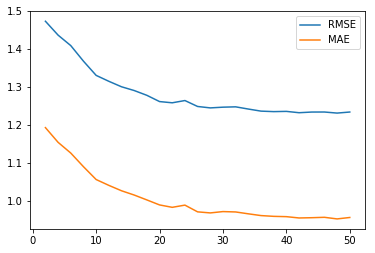

Finishing Plotting...
For RMSE:
	---Optimal number of latent factors is  48
	---Minumun Average RMSE is  1.2309658751433832

For MAE:
	---Optimal number of latent factors is  48
	---Minumun Average MAE is  0.9517415997800779


In [8]:
# Q20
dims = range(2, 51, 2)
NMF_trim_filter(ratings, dims, unpop_trim, mv_dict)

For k = 2 :
RMSE:  2.0047015318594084
MAE:  1.7011687076342163
For k = 4 :
RMSE:  1.8778445382344615
MAE:  1.6004844933552813
For k = 6 :
RMSE:  1.840850012756875
MAE:  1.5660636267823533
For k = 8 :
RMSE:  1.714616529724119
MAE:  1.4787760881398173
For k = 10 :
RMSE:  1.7237599085750694
MAE:  1.4711002231946946
For k = 12 :
RMSE:  1.726047167631713
MAE:  1.456900390351357
For k = 14 :
RMSE:  1.7187002369462625
MAE:  1.474381099784117
For k = 16 :
RMSE:  1.6887357093627684
MAE:  1.4315388925419354
For k = 18 :
RMSE:  1.689553244963843
MAE:  1.416429638445611
For k = 20 :
RMSE:  1.6947244798041303
MAE:  1.4196986455837937
For k = 22 :
RMSE:  1.709210077178079
MAE:  1.4248621508163173
For k = 24 :
RMSE:  1.6939752156946941
MAE:  1.3949085651407898
For k = 26 :
RMSE:  1.6995349884757271
MAE:  1.4062612013878515
For k = 28 :
RMSE:  1.7364249626164585
MAE:  1.4345079203888065
For k = 30 :
RMSE:  1.6285865179141747
MAE:  1.3583730805318095
For k = 32 :
RMSE:  1.7183256270574874
MAE:  1.40796

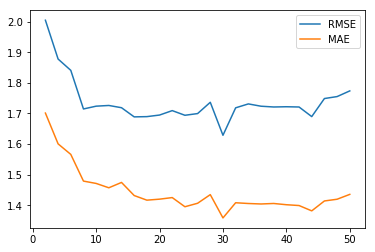

Finishing Plotting...
For RMSE:
	---Optimal number of latent factors is  30
	---Minumun Average RMSE is  1.6285865179141747

For MAE:
	---Optimal number of latent factors is  30
	---Minumun Average MAE is  1.3583730805318095


In [9]:
# Q21
dims = range(2, 51, 2)
NMF_trim_filter(ratings, dims, high_var_trim, mv_dict)

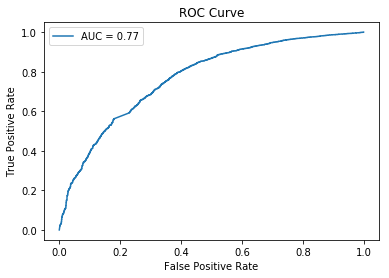

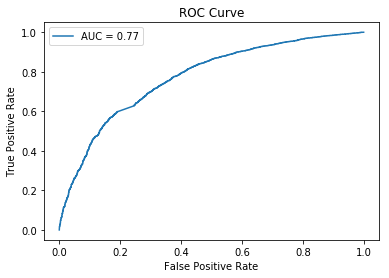

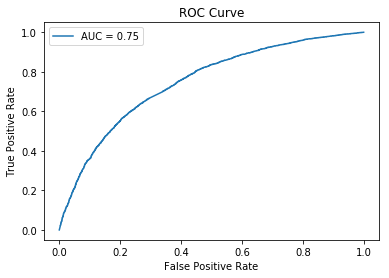

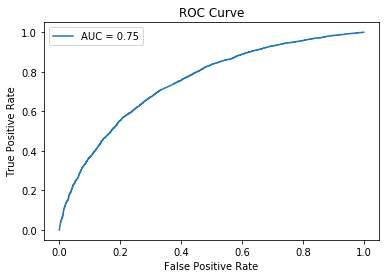

In [6]:
# Q22
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

def plot_roc(pre, tar):
    fpr, tpr, _ = roc_curve(tar, pre)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC = %0.2f' %roc_auc)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.show()
    
def NMF_bin_pre(ratings, ts, nmf_fac, thrd):
    reader = Reader(rating_scale=(0.0, 5.0))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=ts)
    algo = NMF(n_factors=nmf_fac, random_state=42)
    algo.fit(trainset)
    pre = algo.test(testset)

    true_rating = np.empty(len(pre))
    pred_rating = np.empty(len(pre))

    for i in range(len(pre)):
        true_rating[i] = pre[i][2]
        pred_rating[i] = pre[i][3]

    bi_rating = np.empty(len(pre))
    one_idx = true_rating >= thrd
    zero_idx = true_rating < thrd
    bi_rating[one_idx] = 1.0
    bi_rating[zero_idx] = 0.0
    
    return bi_rating, pred_rating
    

threshold = np.array([2.5, 3, 3.5, 4])
for td in threshold:
    tar, pre = NMF_bin_pre(ratings, 0.1, 20, td)
    plot_roc(pre, tar)

In [11]:
# Q23
reader = Reader(rating_scale=(0.0, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data = data.build_full_trainset()
nmf = NMF(n_factors=20, random_state=42)
nmf.fit(data)

In [12]:
for i in range(10):
    col = nmf.qi[:,i]
    top_movie = col.argsort()[::-1][:10]
    print ('For the %i th column, the top 10 movie genres are:' %(i+1))
    for j in range(10):
        raw_iid = nmf.trainset.to_raw_iid(top_movie[j])
        gen = movies.loc[movies['movieId']==raw_iid]['genres'].values
        print ('\t--%i :' %(j+1), gen)

For the 1 th column, the top 10 movie genres are:
	--1 : ['Drama|War']
	--2 : ['Drama|Mystery|Romance']
	--3 : ['Action|Comedy|Crime|Fantasy']
	--4 : ['Action|Adventure|Sci-Fi|War|IMAX']
	--5 : ['Comedy|Documentary']
	--6 : ['Children|Comedy']
	--7 : ['Drama']
	--8 : ['Comedy|Romance']
	--9 : ['Comedy']
	--10 : ['Action|Adventure|Animation|Children|Comedy|Romance']
For the 2 th column, the top 10 movie genres are:
	--1 : ['Adventure|Animation']
	--2 : ['Comedy|Documentary']
	--3 : ['Musical']
	--4 : ['Drama|Fantasy|Horror']
	--5 : ['Comedy']
	--6 : ['Comedy|Romance']
	--7 : ['Drama|War']
	--8 : ['Drama|Fantasy|Mystery|Romance']
	--9 : ['Drama|Romance|War']
	--10 : ['Comedy']
For the 3 th column, the top 10 movie genres are:
	--1 : ['Adventure|Drama|Fantasy|Romance']
	--2 : ['Action|War']
	--3 : ['Action|Adventure|Drama|Thriller']
	--4 : ['Comedy']
	--5 : ['Action|Crime|Thriller']
	--6 : ['Comedy|Drama|Romance']
	--7 : ['Comedy']
	--8 : ['Comedy']
	--9 : ['Comedy|Mystery|Thriller']
	--1

In [8]:
# Q24 & 25
from surprise.prediction_algorithms.matrix_factorization import SVD

def MF_bias_filter(ratings, dims):
    reader = Reader(rating_scale=(0.0, 5.0))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    RMSE = np.empty([len(dims)])
    MAE = np.empty([len(dims)])
    min_RMSE = False
    min_MAE = False
    fac_num_RMSE = 0
    fac_num_MAE = 0

    for k in range(len(dims)):
        svd = SVD(n_factors=dims[k], random_state=42)
        cv = cross_validate(algo=svd, data=data, measures=['RMSE', 'MAE'],
                            cv=10, verbose=True)
        RMSE[k] = np.mean(cv['test_rmse']) 
        if ((not min_RMSE) or RMSE[k] < min_RMSE):
            min_RMSE = RMSE[k]
            fac_num_RMSE = dims[k]

        MAE[k] = np.mean(cv['test_mae'])
        if ((not min_MAE) or MAE[k] < min_MAE):
            min_MAE = MAE[k]
            fac_num_MAE = dims[k]

    plt.plot(dims, RMSE)
    plt.plot(dims, MAE)
    plt.legend(['RMSE', 'MAE'])
    plt.show()
    print ('Finishing Plotting...')
    print ('For RMSE:')
    print ('\t---Optimal number of latent factors is ', fac_num_RMSE)
    print ('\t---Minumun Average RMSE is ', min_RMSE)
    print ('\nFor MAE:')
    print ('\t---Optimal number of latent factors is ', fac_num_MAE)
    print ('\t---Minumun Average MAE is ', min_MAE)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.6796  0.6793  0.6824  0.6831  0.6910  0.6968  0.6829  0.6823  0.6783  0.6714  0.6827  0.0066  
RMSE (testset)    0.8759  0.8866  0.8876  0.8877  0.8991  0.9019  0.8897  0.8886  0.8809  0.8696  0.8868  0.0092  
Fit time          1.20    1.21    1.26    1.24    1.20    1.24    1.21    1.22    1.20    1.11    1.21    0.04    
Test time         0.09    0.08    0.09    0.08    0.08    0.08    0.08    0.08    0.07    0.07    0.08    0.01    
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.6771  0.6806  0.6886  0.6810  0.6930  0.6862  0.6745  0.6776  0.6881  0.6902  0.6837  0.0060  
RMSE (testset)    0.8834  0.8808  0.8969  0.8836  0.9027  0.8888  0.8798  0.8789  0.8

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.6799  0.6982  0.6857  0.6800  0.6895  0.6803  0.6792  0.6745  0.6822  0.6756  0.6825  0.0067  
RMSE (testset)    0.8828  0.9066  0.8922  0.8858  0.8956  0.8887  0.8823  0.8780  0.8794  0.8834  0.8875  0.0083  
Fit time          2.20    2.18    2.20    2.18    2.17    2.19    2.20    2.19    2.24    2.04    2.18    0.05    
Test time         0.11    0.09    0.09    0.11    0.09    0.09    0.09    0.08    0.08    0.07    0.09    0.01    
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     0.6844  0.6774  0.6755  0.6926  0.6848  0.6761  0.6999  0.6837  0.6746  0.6982  0.6847  0.0089  
RMSE (testset)    0.8883  0.8820  0.8747  0.8993  0.8951  0.8765  0.9096  0.8887  0.8

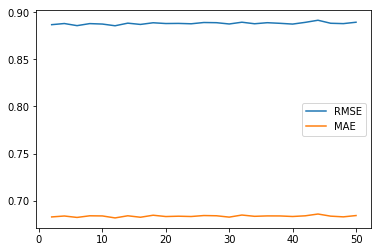

Finishing Plotting...
For RMSE:
	---Optimal number of latent factors is  12
	---Minumun Average RMSE is  0.8855965537043776

For MAE:
	---Optimal number of latent factors is  12
	---Minumun Average MAE is  0.6816601761434223


In [14]:
dims = range(2, 51, 2)
MF_bias_filter(ratings, dims)

In [15]:
# Q26
def MF_trim_filter(ratings, dims, func, mv_dict):
    reader = Reader(rating_scale=(0.0, 5.0))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    RMSE = np.empty([len(dims)])
    MAE = np.empty([len(dims)])
    min_RMSE = False
    min_MAE = False
    fac_num_RMSE = 0
    fac_num_MAE = 0
    kf = KFold(n_splits=10, random_state=42)

    for k in range(len(dims)):
        svd = SVD(n_factors=dims[k], random_state=42)
        test_rmse = np.array([])
        test_mae = np.array([])
        for trainset, testset in kf.split(data):
            svd.fit(trainset)
            full_data = trainset.build_testset() + testset
            func(mv_dict, testset)
            pred = svd.test(testset)
            test_rmse = np.append(test_rmse, accuracy.rmse(pred, verbose=False))
            test_mae = np.append(test_mae, accuracy.mae(pred, verbose=False))
        RMSE[k] = np.mean(test_rmse) 
        if ((not min_RMSE) or RMSE[k] < min_RMSE):
            min_RMSE = RMSE[k]
            fac_num_RMSE = dims[k]

        MAE[k] = np.mean(test_mae)
        if ((not min_MAE) or MAE[k] < min_MAE):
            min_MAE = MAE[k]
            fac_num_MAE = dims[k]
        print ('For k = %i :' %dims[k])
        print ('RMSE: ', RMSE[k])
        print ('MAE: ', MAE[k])

    plt.plot(dims, RMSE)
    plt.plot(dims, MAE)
    plt.legend(['RMSE', 'MAE'])
    plt.show()
    print ('Finishing Plotting...')
    print ('For RMSE:')
    print ('\t---Optimal number of latent factors is ', fac_num_RMSE)
    print ('\t---Minumun Average RMSE is ', min_RMSE)
    print ('\nFor MAE:')
    print ('\t---Optimal number of latent factors is ', fac_num_MAE)
    print ('\t---Minumun Average MAE is ', min_MAE)
    

For k = 2 :
RMSE:  0.8796083548524283
MAE:  0.6772831198701011
For k = 4 :
RMSE:  0.8792254591470379
MAE:  0.6768135775304928
For k = 6 :
RMSE:  0.8808357839348444
MAE:  0.6781095488828515
For k = 8 :
RMSE:  0.8799121044062902
MAE:  0.6770086485659247
For k = 10 :
RMSE:  0.8801690824656344
MAE:  0.6774031782975871
For k = 12 :
RMSE:  0.8811498782632199
MAE:  0.6781850467831562
For k = 14 :
RMSE:  0.8804997749491423
MAE:  0.6776622803236519
For k = 16 :
RMSE:  0.8809046213516336
MAE:  0.6777049829533415
For k = 18 :
RMSE:  0.8800380824779687
MAE:  0.676790297386889
For k = 20 :
RMSE:  0.8802716215255011
MAE:  0.6772818668577429
For k = 22 :
RMSE:  0.8796006599120929
MAE:  0.676758680379544
For k = 24 :
RMSE:  0.8794696781766183
MAE:  0.6762328339790513
For k = 26 :
RMSE:  0.8790900484270333
MAE:  0.6759489653708559
For k = 28 :
RMSE:  0.8803180907411079
MAE:  0.6775109966552254
For k = 30 :
RMSE:  0.8811954075333078
MAE:  0.677600598889057
For k = 32 :
RMSE:  0.8802043243637081
MAE:  0.

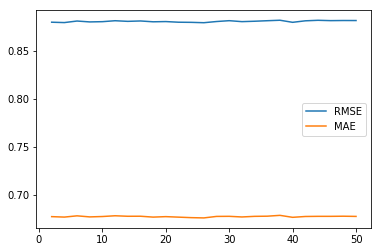

Finishing Plotting...
For RMSE:
	---Optimal number of latent factors is  26
	---Minumun Average RMSE is  0.8790900484270333

For MAE:
	---Optimal number of latent factors is  26
	---Minumun Average MAE is  0.6759489653708559


In [16]:
# Q26
dims = range(2, 51, 2)
MF_trim_filter(ratings, dims, pop_trim, mv_dict)

For k = 2 :
RMSE:  1.0141169384847717
MAE:  0.7898647405660941
For k = 4 :
RMSE:  1.0141887844462554
MAE:  0.7902733281913298
For k = 6 :
RMSE:  1.015004993689855
MAE:  0.7906075203751219
For k = 8 :
RMSE:  1.0140209810935519
MAE:  0.7895504433945947
For k = 10 :
RMSE:  1.0141355844147604
MAE:  0.7902100823111982
For k = 12 :
RMSE:  1.0159846970909794
MAE:  0.7910929146879189
For k = 14 :
RMSE:  1.015275504578494
MAE:  0.7906433740131684
For k = 16 :
RMSE:  1.0136445344004406
MAE:  0.7888016888308967
For k = 18 :
RMSE:  1.0132302483235358
MAE:  0.7884772494546193
For k = 20 :
RMSE:  1.014480846436848
MAE:  0.7899595943032349
For k = 22 :
RMSE:  1.0165142702995493
MAE:  0.7904293554724384
For k = 24 :
RMSE:  1.0141008776827285
MAE:  0.7907054090684257
For k = 26 :
RMSE:  1.0147336470927792
MAE:  0.7900678776759357
For k = 28 :
RMSE:  1.0134057150909666
MAE:  0.7901554397162924
For k = 30 :
RMSE:  1.0146328382756373
MAE:  0.7896628270507089
For k = 32 :
RMSE:  1.013644850815557
MAE:  0.7

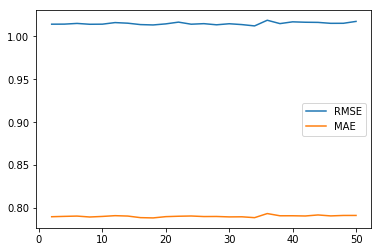

Finishing Plotting...
For RMSE:
	---Optimal number of latent factors is  34
	---Minumun Average RMSE is  1.012107308422905

For MAE:
	---Optimal number of latent factors is  18
	---Minumun Average MAE is  0.7884772494546193


In [17]:
# Q27
dims = range(2, 51, 2)
MF_trim_filter(ratings, dims, unpop_trim, mv_dict)

For k = 2 :
RMSE:  1.5147431649487295
MAE:  1.2974006735877022
For k = 4 :
RMSE:  1.5081165888700445
MAE:  1.2902120739026997
For k = 6 :
RMSE:  1.5160996283049755
MAE:  1.298486662160076
For k = 8 :
RMSE:  1.5217128793445052
MAE:  1.2988394352986927
For k = 10 :
RMSE:  1.5159804205163088
MAE:  1.2936018113084793
For k = 12 :
RMSE:  1.5185131831057834
MAE:  1.3013389685578831
For k = 14 :
RMSE:  1.5100762860320487
MAE:  1.2916674554066767
For k = 16 :
RMSE:  1.5226670069951889
MAE:  1.3015983860816733
For k = 18 :
RMSE:  1.5135699414518355
MAE:  1.2933477888785097
For k = 20 :
RMSE:  1.5065062012888628
MAE:  1.2869785361054675
For k = 22 :
RMSE:  1.5062630088437552
MAE:  1.2891054128290567
For k = 24 :
RMSE:  1.5184555972835079
MAE:  1.2977690682783203
For k = 26 :
RMSE:  1.5152692703605577
MAE:  1.294953523106372
For k = 28 :
RMSE:  1.5021520563477593
MAE:  1.2872465873096615
For k = 30 :
RMSE:  1.505178878564946
MAE:  1.2830426412049412
For k = 32 :
RMSE:  1.519645505071262
MAE:  1.3

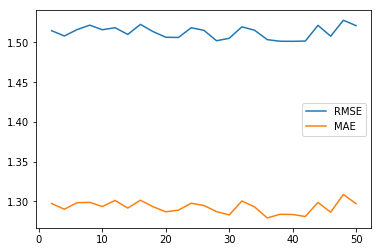

Finishing Plotting...
For RMSE:
	---Optimal number of latent factors is  40
	---Minumun Average RMSE is  1.501397958988729

For MAE:
	---Optimal number of latent factors is  36
	---Minumun Average MAE is  1.2793057699873862


In [18]:
# Q28
dims = range(2, 51, 2)
MF_trim_filter(ratings, dims, high_var_trim, mv_dict)

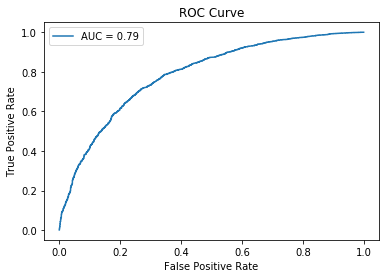

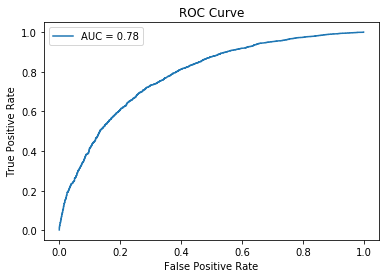

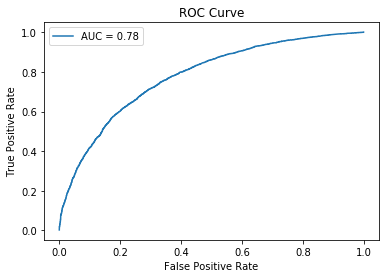

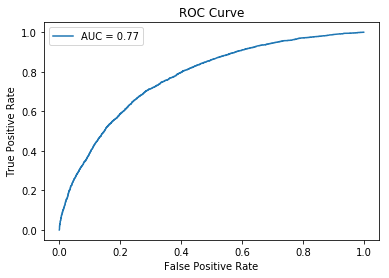

In [9]:
# Q29
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

def plot_roc(pre, tar):
    fpr, tpr, _ = roc_curve(tar, pre)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC = %0.2f' %roc_auc)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.show()
    
def MF_bin_pre(ratings, ts, nmf_fac, thrd):
    reader = Reader(rating_scale=(0.0, 5.0))
    data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=ts)
    algo = SVD(n_factors=nmf_fac, random_state=42)
    algo.fit(trainset)
    pre = algo.test(testset)

    true_rating = np.empty(len(pre))
    pred_rating = np.empty(len(pre))

    for i in range(len(pre)):
        true_rating[i] = pre[i][2]
        pred_rating[i] = pre[i][3]

    bi_rating = np.empty(len(pre))
    one_idx = true_rating >= thrd
    zero_idx = true_rating < thrd
    bi_rating[one_idx] = 1.0
    bi_rating[zero_idx] = 0.0
    
    return bi_rating, pred_rating
    

threshold = np.array([2.5, 3, 3.5, 4])
for td in threshold:
    tar, pre = MF_bin_pre(ratings, 0.1, 12, td)
    plot_roc(pre, tar)

In [8]:
##  Part 8
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import Reader

def read_data(filename):
    df = pd.read_csv(filename, delimiter=',')
    return df

ratings = read_data('ratings.csv')

In [9]:
def process_prediction(pred, t, threshold):
    pred_likes = {}
    for p in pred:
        if p.uid not in pred_likes.keys():
            pred_likes[p.uid] = [[p.iid, p.r_ui, p.est]]
        else:
            pred_likes[p.uid].append([p.iid, p.r_ui, p.est])
    
    precisoin = []
    recall = []
    for user in pred_likes:
        if len(pred_likes[user]) < t: 
            continue
        iid_rui_est = np.array(pred_likes[user])
        S_t = iid_rui_est[iid_rui_est[:,2].argsort()[::-1]][:,0][0:t]
        G = [data[0] for data in iid_rui_est if data[1] >= threshold]
        GS = np.intersect1d(S_t, G)
        if len(G) <= 0:
            continue
        precision.append(float(len(GS))/len(S_t))
        recall.append(float(len(GS))/len(G))
    return np.mean(precision), np.mean(recall)


In [10]:
# Q37
# Generate the dictionary of User -> Liked Movies
from surprise.model_selection import train_test_split
reader = Reader(rating_scale=(0.0, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
#empty_ds, full_ds = train_test_split(data, test_size=1.0, random_state=42)

For 1 : 
Precision :  0.9279356656458719
Recall :  0.2194355266901594
For 2 : 
Precision :  0.9156973492417492
Recall :  0.3514311084239487
For 3 : 
Precision :  0.9119215808219268
Recall :  0.4176418667006948
For 4 : 
Precision :  0.9110877506489321
Recall :  0.4574879944968937
For 5 : 
Precision :  0.9108872389134404
Recall :  0.48348046769693465
For 6 : 
Precision :  0.9113376697892059
Recall :  0.5012367785049063
For 7 : 
Precision :  0.9094761954325816
Recall :  0.5175955754949021
For 8 : 
Precision :  0.9049908863368831
Recall :  0.525406143335782
For 9 : 
Precision :  0.9043968728568618
Recall :  0.5378772976455035
For 10 : 
Precision :  0.9013537283803984
Recall :  0.5475969650570712
For 11 : 
Precision :  0.8994099389327855
Recall :  0.5592448086531743
For 12 : 
Precision :  0.897511182015498
Recall :  0.5693472572934944
For 13 : 
Precision :  0.8972330522614819
Recall :  0.5803312923678545
For 14 : 
Precision :  0.8947183269536835
Recall :  0.591099170996856
For 15 : 
Precisi

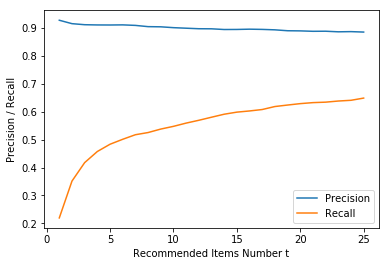

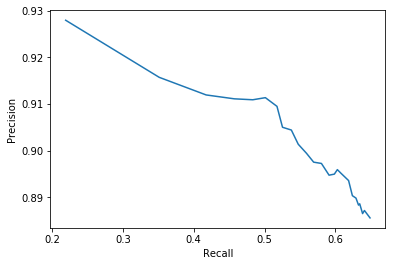

In [11]:
precision_nmf = []
recall_nmf = []
reco_num = range(1, 26)

for t in reco_num:
    kf = KFold(n_splits=10, random_state=42)
    nmf = NMF(n_factors=20, random_state=42)
    precision = []
    recall = []
    for trainset, testset in kf.split(data):
        nmf.fit(trainset)
        pred = nmf.test(testset)
        r1, r2 = process_prediction(pred, t, 3)
        precision.append(r1)
        recall.append(r2)
    precision_nmf.append(np.mean(precision))
    recall_nmf.append(np.mean(recall))
    print ('For %i : ' %t)
    print ('Precision : ', precision_nmf[t-1])
    print ('Recall : ', recall_nmf[t-1])
    
plt.plot(reco_num, precision_nmf)
plt.plot(reco_num, recall_nmf)
plt.legend(['Precision', 'Recall'])
plt.xlabel('Recommended Items Number t')
plt.ylabel('Precision / Recall')
plt.show()

plt.plot(recall_nmf, precision_nmf) 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

For 1 : 
Precision :  0.9375171122043955
Recall :  0.22129770228002538
For 2 : 
Precision :  0.9238870709532286
Recall :  0.3527649013772722
For 3 : 
Precision :  0.9193085193980951
Recall :  0.41927070234998826
For 4 : 
Precision :  0.9197381629268657
Recall :  0.4604143125481774
For 5 : 
Precision :  0.9183792913207669
Recall :  0.4858628868997557
For 6 : 
Precision :  0.9185705534028995
Recall :  0.5036452889975696
For 7 : 
Precision :  0.9177954943674641
Recall :  0.5210508616789753
For 8 : 
Precision :  0.9144828867075451
Recall :  0.5291886229338391
For 9 : 
Precision :  0.9141995321689308
Recall :  0.5429856571428815
For 10 : 
Precision :  0.9110011622219467
Recall :  0.5528986518357819
For 11 : 
Precision :  0.9090521774155853
Recall :  0.5650404179877825
For 12 : 
Precision :  0.9065721576436381
Recall :  0.5746679989185669
For 13 : 
Precision :  0.9056807937765423
Recall :  0.5848791477036878
For 14 : 
Precision :  0.903349728050507
Recall :  0.5960457424767143
For 15 : 
Prec

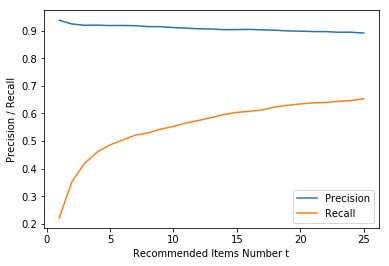

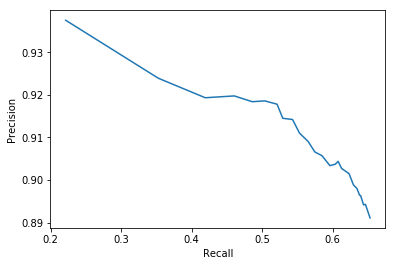

In [12]:
# Q38
from surprise.prediction_algorithms.matrix_factorization import SVD
precision_svd = []
recall_svd = []
reco_num = range(1, 26)

for t in reco_num:
    kf = KFold(n_splits=10, random_state=42)
    precision = []
    recall = []
    svd = SVD(n_factors=18, random_state=42)
    for trainset, testset in kf.split(data):
        svd.fit(trainset)
        pred = svd.test(testset)
        r1, r2 = process_prediction(pred, t, 3)
        precision.append(r1)
        recall.append(r2)
    precision_svd.append(np.mean(precision))
    recall_svd.append(np.mean(recall))
    print ('For %i : ' %t)
    print ('Precision : ', precision_svd[t-1])
    print ('Recall : ', recall_svd[t-1])
    
plt.plot(reco_num, precision_svd)
plt.plot(reco_num, recall_svd)
plt.legend(['Precision', 'Recall'])
plt.xlabel('Recommended Items Number t')
plt.ylabel('Precision / Recall')
plt.show()

plt.plot(recall_svd, precision_svd) 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

t = 1 is done!
t = 2 is done!
t = 3 is done!
t = 4 is done!
t = 5 is done!
t = 6 is done!
t = 7 is done!
t = 8 is done!
t = 9 is done!
t = 10 is done!
t = 11 is done!
t = 12 is done!
t = 13 is done!
t = 14 is done!
t = 15 is done!
t = 16 is done!
t = 17 is done!
t = 18 is done!
t = 19 is done!
t = 20 is done!
t = 21 is done!
t = 22 is done!
t = 23 is done!
t = 24 is done!
t = 25 is done!


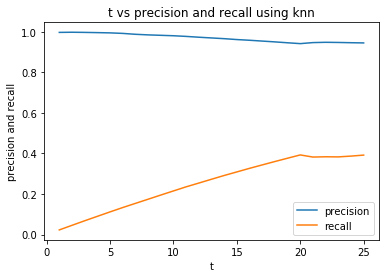

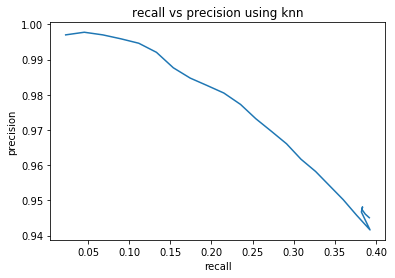

In [5]:
import numpy as np
import csv
import matplotlib.pyplot as plt

# a class that stores ratings for one user
class user_rating:
    def __init__(self, userid, movies, ratings):
        self.userid = userid # a int number
        self.movies = movies # a string list
        self.avg = np.mean(ratings) # a float number
        self.ratings = dict(zip(movies, ratings)) # a dictionary mapping ratings to movies
        G = set() # movies the user likes
        for key, val in self.ratings.items():
            if val >= 3:
                G.add(key)
        self.G = G
                
    def display(self):
        print (self.userid)
        print (self.ratings)
        print (self.G)

# calculate Pearson-correlation coefficient      
def pearson(u, v):
    I = list(set(u.movies)&set(v.movies))
    if not I:
        return 0
    else:
        uk = []
        vk = []
        for id in I:
            uk.append(u.ratings[id])
            vk.append(v.ratings[id])
        uk = np.asarray(uk)
        vk = np.asarray(vk)
        uk -= u.avg
        vk -= v.avg
        tmp1 = np.sum(uk*vk)
        tmp2 = np.sqrt(np.sum(np.square(uk)))
        tmp3 = np.sqrt(np.sum(np.square(vk)))
        p = tmp1/(tmp2*tmp3+1e-9) # to avoid division by zero
        return p

# predict movie ratings of users in testset using information from trainset        
def knn(trainset, testset, k):
    res = []
    for user_test in testset:
        p = []
        for user_train in trainset:
            p.append(pearson(user_test, user_train))
        idx = np.argsort(p)[::-1][:k]
        topk = []
        for i in range(k):
            topk.append(trainset[idx[i]])
        sum = 0
        for i in idx:
            sum += abs(p[i])
        pred = []
        for movie in user_test.movies:
            tmp = user_test.avg
            for user in topk:
                if movie in user.movies:
                    tmp += pearson(user_test, user)*(user.ratings[movie]-user.avg)/sum
            pred.append(tmp)
        res.append(dict(zip(user_test.movies, pred)))
    return res

# give top t movies
def rank(pred, t):
    movies = list(pred.keys())
    ratings = list(pred.values())
    idx = np.argsort(ratings)[::-1][:t]
    recommend = []
    for i in range(t):
        recommend.append(movies[idx[i]])
    return recommend

# cross validation to get precision and recall given a spceific t
def rank_t(users, t):
    num_folds = 10
    folds = []
    precision_folds = []
    recall_folds = []
    for i in range(num_folds):
        folds.append(users[int(i*len(users)/num_folds):int((i+1)*len(users)/num_folds)])
    for i in range(num_folds):
        testset = folds[i]
        trainset = []
        for j in range(num_folds):
            if j != i:
                trainset.extend(folds[j])
        res = knn(trainset, testset, k = 30)
        precision = 0
        recall = 0
        size = len(testset)
        for k in range(size):        
            G = testset[k].G
            if len(testset[k].movies) < t or not G:
                size -= 1
                continue
            else:
                S = set(rank(res[k], t))
                I = S&G
                precision += len(I)/len(S)
                recall += len(I)/len(G)
        if size:
            precision_folds.append(precision/size)
            recall_folds.append(recall/size)
        else:
            continue
    precision_t = np.mean(precision_folds)
    recall_t = np.mean(recall_folds)
    print ('t = ' + str(t) + ' is done!')
    return precision_t, recall_t

# create a list that contains 671 user_rating objects
data = []    
with open('ratings.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        if row[0] != 'userId':
            data.append((int(row[0]), row[1], float(row[2])))
data.append((0,0,0)) # a dummy data point to avoid index out of bounds
users = []
pointer = 0
for id in range(1, 672):
    movies = []
    ratings = []
    flag = 1
    while flag:
        if data[pointer][0] == id:
            movies.append(data[pointer][1])
            ratings.append(data[pointer][2])
        if data[pointer+1][0] == id:
            pointer += 1
        else:
            flag = 0
    users.append(user_rating(id, movies, ratings))

# test on different t
ts = list(range(1, 26))
precision_knn = []
recall_knn = []
for t in ts:
    p, r = rank_t(users, t)
    precision_knn.append(p)
    recall_knn.append(r)
plt.plot(ts, precision_knn, ts, recall_knn)
plt.xlabel('t')
plt.ylabel('precision and recall')
plt.title('t vs precision and recall using knn')
plt.legend(['precision', 'recall'])
plt.show()
plt.plot(recall_knn, precision_knn)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('recall vs precision using knn')

plt.show()    

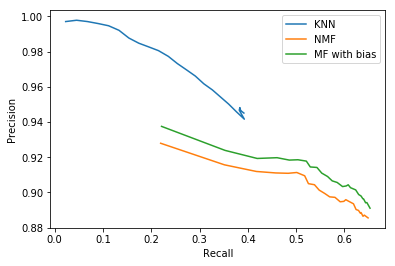

In [13]:
# Q39
plt.plot(recall_knn, precision_knn)
plt.plot(recall_nmf, precision_nmf)
plt.plot(recall_svd, precision_svd)

plt.legend(['KNN','NMF', 'MF with bias'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [18]:
import pandas as pd
dict = {'a':1, 'b':2, 'x':3}
def f1(cha):
    return 'z'
a = [['a', '1.2', '4.2'], ['b', '70', '0.03'], ['x', '5', '0']]
df = pd.DataFrame(a)
df[0] = df[0].apply(lambda x: dict[x])
df

,0,1,2
0,1,1.2,4.2
1,2,70,0.03
2,3,5,0
